# The Fourier Transform

In [1]:
# Code from previous section
using Plots
Base.showable(::MIME"image/svg+xml", ::Plots.Plot) = false  # Disable SVG

using FileIO

to3Darray(img) = Float32[ getfield(pxl, fld) for pxl in img, fld in (:r,:g,:b) ]
toRGBarray(img) = RGB.(eachslice(img[:,:,:], dims=3)...)
imread(filename) = to3Darray(load(filename))
imshow(img; args...) = plot(toRGBarray(img); aspect_ratio=:equal, axis=nothing, border=:none, args...)

imshow (generic function with 1 method)

In [2]:
# Read sample image and convert to grayscale
A = imread("sample_photo.png")
B = sum(A, dims=3) / 3;

The **2D Discrete Fourier Transform (DFT)** is a fundamental tool that allows us to view an image from a completely different perspective. Instead of seeing it as a grid of pixel intensities (the *spatial domain*), the DFT decomposes the image into a sum of 2D sine and cosine waves of different frequencies and amplitudes (the *frequency domain*).

The DFT $F(u,v)$ of an $m \times n$ image $f(x,y)$ is defined as:

$$
   F(u,v) = \sum_{x=0}^{m-1} \sum_{y=0}^{n-1} f(x,y)
  \exp \left[-2\pi i \left(\frac{xu}{m} + \frac{yv}{n}\right) \right]
$$

The pair $(u, v)$ represents a specific 2D frequency. The value of $F(u,v)$ is a complex number whose *magnitude* tells us "how much" of that frequency is present in the original image.

The inverse transform (IDFT) reconstructs the original image from its frequency components:

$$
f(x,y) = \frac{1}{mn} \sum_{u=0}^{m-1} \sum_{v=0}^{n-1} F(u,v)
  \exp \left[2\pi i \left(\frac{xu}{m} + \frac{yv}{n}\right) \right]
$$

This "frequency-space" representation is incredibly useful for tasks like:
* **Fast filtering (convolution)**
* **Image compression**
* **Detecting periodic patterns (like noise or textures)**

## Visualizing the Fourier Spectrum

Let's plot the Fourier coefficients for some simple images. Since the coefficients $F(u,v)$ are complex numbers, we can't plot them directly as an image. Instead, we'll visualize the **power spectrum**, which is the *magnitude* (or *absolute value*) of each coefficient.

Because the magnitudes can vary wildly (the $F(0,0)$ "DC component" is often huge), we will plot $\log(1 + |F(u,v)|)$. This logarithmic scaling compresses the range and makes the patterns in the smaller coefficients visible.

In [3]:
using FFTW

function imagefft_demo(A)
    # 1. Compute the 2D Fast Fourier Transform (FFT)
    # `fft(A)` returns an array where the (0,0) frequency is at index 1,1.
    # We use `fftshift` to move this (0,0) frequency (the "DC component")
    # to the center of the array, which is more intuitive for visualization.
    AF = fftshift(fft(A))

    # 2. Compute the log-magnitude for plotting
    # We use log(1 + ...) so that `log(0)` is not undefined.
    # The `@.` macro broadcasts the log, abs, and + operations.
    AF_plot = @. log(1 + abs(AF))

    # 3. Normalize the plot to the [0, 1] range for imshow
    AF_plot .-= minimum(AF_plot)
    AF_plot ./= maximum(AF_plot)

    # 4. Plot the original image and its spectrum side-by-side
    plt1 = imshow(A, title="Spatial Domain")
    plt2 = imshow(AF_plot, title="Frequency Domain (Log-Magnitude)")
    plot(plt1, plt2, layout=(1,2), titlefontsize=10)
end

imagefft_demo (generic function with 1 method)

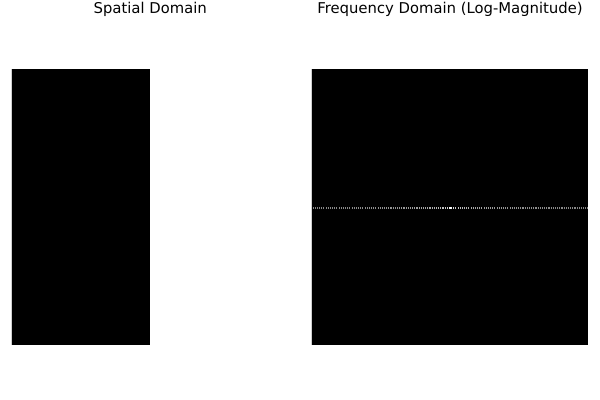

In [4]:
# A simple image: half black, half white.
# This is a sharp vertical edge.
# The spectrum shows a bright horizontal line, 
# indicating high frequencies in the horizontal direction.
G = [zeros(256,128) ones(256,128)]
imagefft_demo(G)

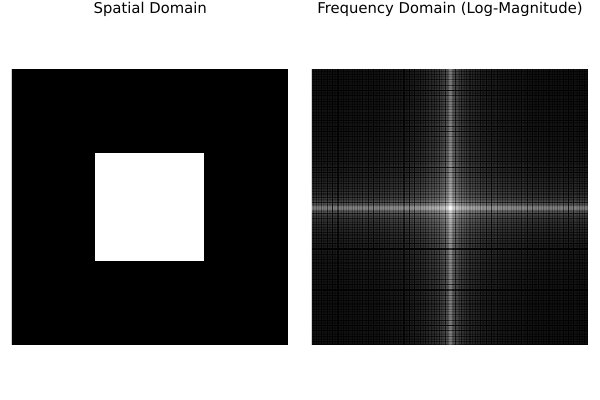

In [5]:
# A white square (or "aperture") on a black background.
# Notice the cross-like pattern ("sinc" function) in the spectrum.
# This is a classic result from "Fourier optics".
G = zeros(256, 256)
G[78:178, 78:178] .= 1.0
imagefft_demo(G)

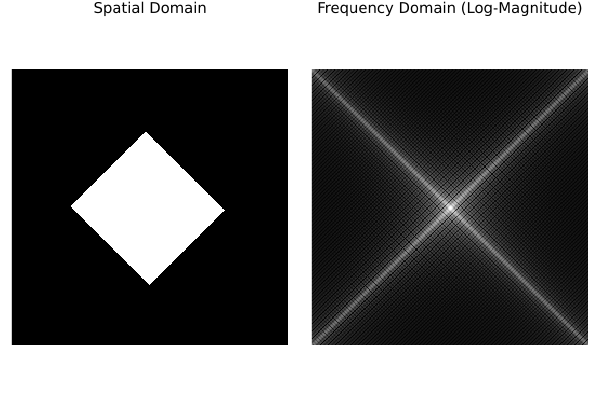

In [6]:
# A rotated square.
# Note how rotating the image in the spatial domain
# *also* rotates its Fourier spectrum by the same amount.
G = Float32[ (i+j<329) && (i+j>182) && (i-j>-67) && (i-j<73) for i = 1:256, j = 1:256 ]
imagefft_demo(G)

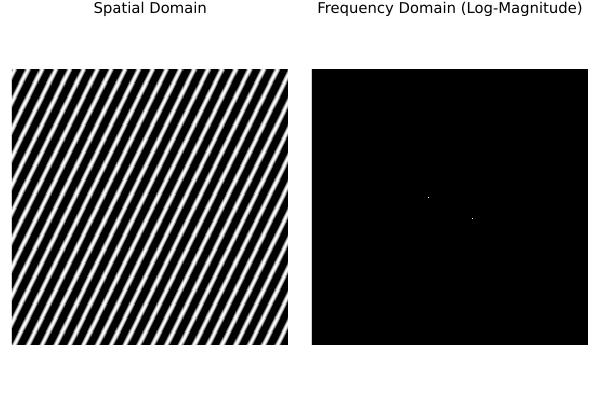

In [7]:
# An image of a single 2D sine wave.
# Its Fourier transform is (ideally) just two points (a "delta function" pair),
# representing that single frequency (and its negative).
G = Float32[ sin(2pi*(10i + 20j)/256) for i = 1:256, j = 1:256 ]
imagefft_demo(G)

As you can see, sharp edges and fine details (high frequencies) correspond to energy *far from the center* of the spectrum. Smooth, large-scale shapes (low frequencies) correspond to energy *near the center*.

For a natural image, the pattern is more complex, but the same principle holds. Most of the energy is concentrated at the low frequencies (the center), with the high-frequency coefficients decaying quickly.

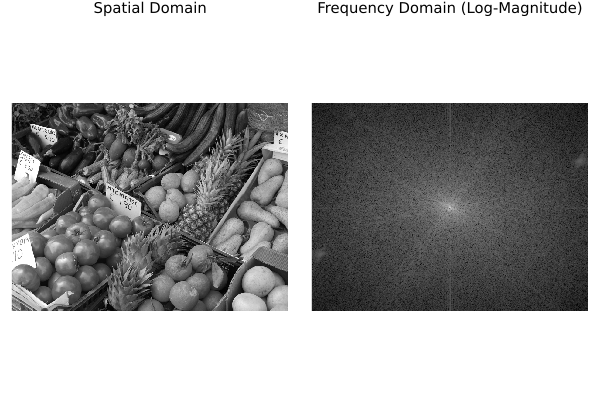

In [8]:
# Now let's look at the spectrum of our real grayscale image
imagefft_demo(B)

## Application: Removing Periodic Noise

One of the most powerful applications of the Fourier transform is filtering. Because specific frequencies are localized to specific points in the frequency domain, we can remove unwanted frequencies by simply setting their coefficients to zero.

Below, we'll add artificial "periodic noise" (a strong sine wave) to our image. This kind of noise might come from electronic interference or a moiré pattern.

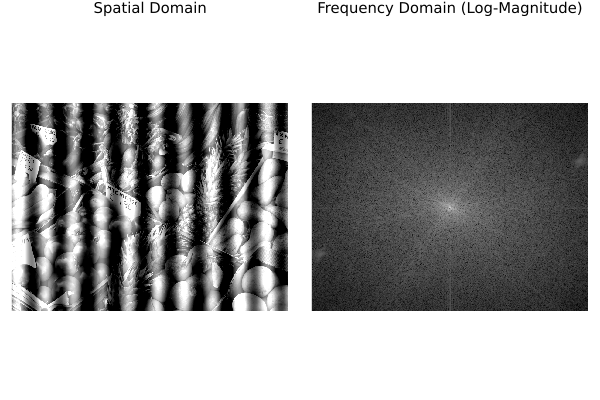

In [9]:
# Create a copy of the grayscale image
Bpernoise = copy(B)

# Add a strong horizontal sine wave (frequency u=0, v=10) as noise
# This creates noticeable horizontal "bars"
noise_wave = 0.5*Float32[sin(2π*10j / size(B,2)) for i = 1:size(B,1), j = 1:size(B,2) ]
Bpernoise = B + noise_wave

# Note the two bright dots in the spectrum, corresponding to the noise!
imagefft_demo(Bpernoise)

In the spectrum above, you can clearly see the two bright dots corresponding to our noise. The rest of the image spectrum is the 'X' pattern in the middle.

To filter the image, we can perform "notch filtering":
1.  Transform the noisy image into the frequency domain (`fft`).
2.  Manually set the coefficients at the noise frequencies to 0.
3.  Transform the image back to the spatial domain (`ifft`).

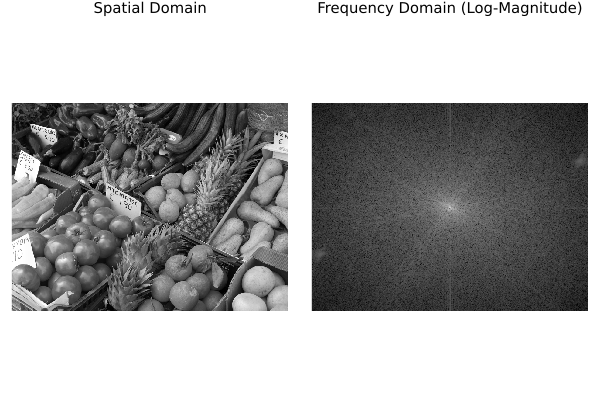

In [10]:
# 1. Transform and shift
BF = fftshift(fft(Bpernoise))

# 2. Find the center pixel and "zap" the noise frequencies
#    `mid` is the (y,x) coordinate of the center (DC) pixel.
mid = size(B) .÷ 2 .+ 1

# Zap the noise pixel at (u=0, v=10) relative to center
BF[mid[1], mid[2] + 10] = 0
# Zap the corresponding symmetric pixel at (u=0, v=-10)
BF[mid[1], mid[2] - 10] = 0

# 3. Undo the shift and perform the inverse FFT
# We take `real.` because the inverse transform may have tiny
# imaginary parts due to floating-point error, but we
# know our result should be purely real.
Bfiltered = real.(ifft(ifftshift(BF)))

# 4. Display the result. The noise bars are gone!
#    (And the spectrum shows two black holes where the noise was)
imagefft_demo(Bfiltered)